In [1]:
import sys
sys.path.append('/home/robin/github/forked/ProtoPool/')

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import json
import sys
from model import PrototypeChooser
from sklearn.cluster import KMeans
import copy
import pandas as pd
from contextlib import contextmanager
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import torchvision.utils as utils
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading data

In [3]:
model_path = '/home/robin/github/forked/ProtoPool/results_analysis/checkpoint/birds_descriptive-10_prototypes-202_lr-0.0005_resnet50_True_log_log_warmup_ll_mixup_iNaturalist_seed-4307_2023-05-06_232259/best_model.pth'

In [4]:
# Load the best model
model = PrototypeChooser(
        num_prototypes=202,
        num_descriptive=10,
        num_classes=100, #200,
        use_thresh=True,
        arch='resnet50',
        pretrained=True,
        add_on_layers_type='log',
        prototype_activation_function='log',
        proto_depth=256,
        use_last_layer=True,
        inat=True)

state_dict = torch.load(model_path)
model.load_state_dict(state_dict['model_state_dict'])
model = model.cuda()
model.eval()

PrototypeChooser(
  (features): resnet50_features
  (add_on_layers): Sequential(
    (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Sigmoid()
  )
  (last_layer): Linear(in_features=1000, out_features=100, bias=False)
)

In [5]:
# Load the datasets
transforms_train_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [6]:
train_in_dataset = datasets.ImageFolder('/home/robin/d/CUB_200_2011/train_cropped_in', transform=transforms_train_test)
train_in_loader = DataLoader(train_in_dataset, batch_size=80, shuffle=False, num_workers=4)

test_in_dataset = datasets.ImageFolder('/home/robin/d/CUB_200_2011/test_cropped_in', transform=transforms_train_test)
test_in_loader = DataLoader(test_in_dataset, batch_size=80, shuffle=False, num_workers=4)

train_out_dataset = datasets.ImageFolder('/home/robin/d/CUB_200_2011/train_cropped_out', transform=transforms_train_test)
train_out_loader = DataLoader(train_out_dataset, batch_size=80, shuffle=False, num_workers=4)

test_out_dataset = datasets.ImageFolder('/home/robin/d/CUB_200_2011/test_cropped_out', transform=transforms_train_test)
test_out_loader = DataLoader(test_out_dataset, batch_size=80, shuffle=False, num_workers=4)

In [7]:
def get_vectors(dataset, loader, model, model_idxs_it_was_trained_on_2_class_names=None):
    
    
    # Evaluate the model on the dataset
    tst_acc, total = 0, 0
    x_activation_diffs = []
    true_model_idxs = []
    pred_model_idxs = []

    correct_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda()
            labels = labels.cuda()

            prob, _, _, (x_activation, x_activation_avg) = model(images, gumbel_scale=10e3)

            x_activation_diffs.extend((x_activation - x_activation_avg).cpu().numpy())
            true_model_idxs.extend(labels.cpu().tolist())

            # sanity check - accuracy:
            _, predicted = torch.max(prob, 1)
            true = labels
            tst_acc += (predicted == true).sum()
            total += labels.size(0)

            pred_model_idxs.extend(predicted.cpu().tolist())
#             correct_pred.extend([1 if pred == true_value else 0 for pred, true_value in zip(predicted, true)])


    tst_acc = tst_acc.item() / total


    model_idx_to_class = {idx:class_name for class_name, idx in dataset.class_to_idx.items()}

    
    if model_idxs_it_was_trained_on_2_class_names:
        
        true_class_names = [model_idx_to_class[l] for l in true_model_idxs]
        pred_class_names = [model_idxs_it_was_trained_on_2_class_names[l] for l in pred_model_idxs]
        
        vectors = {
            'true_model_idxs':true_model_idxs,
            'pred_model_idxs':pred_model_idxs,
            'true_class_names':true_class_names,
            'pred_class_names': pred_class_names,
            'x_activation_diffs':x_activation_diffs,
#             'correct_pred': correct_pred
        }
        
        return vectors
    
    else:
        print(f'Accuracy: {tst_acc * 100:.2f}%')
        
        true_class_names = [model_idx_to_class[l] for l in true_model_idxs]
        pred_class_names = [model_idx_to_class[l] for l in pred_model_idxs]

        vectors = {
            'true_model_idxs':true_model_idxs,
            'pred_model_idxs':pred_model_idxs,
            'true_class_names':true_class_names,
            'pred_class_names': pred_class_names,
            'x_activation_diffs':x_activation_diffs,
#             'correct_pred': correct_pred
        }
        return vectors, model_idx_to_class

In [8]:
train_in_vectors, model_idx_to_class = get_vectors(train_in_dataset, train_in_loader, model)
test_in_vectors, _ = get_vectors(test_in_dataset, test_in_loader, model)

train_out_vectors = get_vectors(train_out_dataset, train_out_loader, model, model_idx_to_class)
test_out_vectors = get_vectors(test_out_dataset, test_out_loader, model, model_idx_to_class)

Accuracy: 100.00%
Accuracy: 89.76%


In [9]:
train_in_df = pd.DataFrame(train_in_vectors)
test_in_df = pd.DataFrame(test_in_vectors)

train_out_df = pd.DataFrame(train_out_vectors)
test_out_df = pd.DataFrame(test_out_vectors)

# How well model trained on train_in_dataset predicts classes that it didn't see? Or rather how well model confuses classes that it knows with classes from test_out_dataset?

In [10]:
data = []

for name, gr in test_out_df.groupby('true_class_names'):
    counts = gr.pred_class_names.value_counts()
    acc = counts.iloc[0] / gr.shape[0]
    acc_rounded = np.round(acc, 2)
    data.append((name, counts.index[0], acc_rounded))

test_out_confused_classes_df = pd.DataFrame(data, columns=['True Class', 'Most Predicted Class', 'Accuracy of most predicted class'])

In [11]:
test_out_confused_classes_df = test_out_confused_classes_df.sort_values(by='Accuracy of most predicted class', ascending=False).reset_index(drop=True)

In [12]:
test_out_confused_classes_df[:55]

,True Class,Most Predicted Class,Accuracy of most predicted class
0,143.Caspian_Tern,144.Common_Tern,0.97
1,014.Indigo_Bunting,054.Blue_Grosbeak,0.97
2,079.Belted_Kingfisher,082.Ringed_Kingfisher,0.97
3,185.Bohemian_Waxwing,186.Cedar_Waxwing,0.93
4,141.Artic_Tern,144.Common_Tern,0.93
5,146.Forsters_Tern,144.Common_Tern,0.90
6,102.Western_Wood_Pewee,040.Olive_sided_Flycatcher,0.90
7,145.Elegant_Tern,144.Common_Tern,0.87
8,176.Prairie_Warbler,169.Magnolia_Warbler,0.87
9,080.Green_Kingfisher,082.Ringed_Kingfisher,0.83


In [13]:
# The same results can be calculated with use of Hungarian algorighm:

# for name, gr in test_out_df.groupby('true_class_names'):

#     cm = confusion_matrix(gr['true_class_names'], gr['pred_class_names'])

#     # Find the optimal assignment using the Hungarian algorithm
#     row_ind, col_ind = linear_sum_assignment(-cm)

#     # Calculate the accuracy
#     adjusted_accuracy = cm[row_ind, col_ind].sum() / np.sum(cm)

#     print(f"Adjusted accuracy for {name}\t", adjusted_accuracy)

# For images from class "143.Caspian_Tern" (from test_out_dataset) model predicts "144.Common_Tern" with accuracy of 97%. It obviously confuses the class it knows with new class it didn't see. Let's check T-SNE of activation vectors for those and other classes that model confuses.

In [14]:
def visualize_tsne(dataset, row):

    # Create T-SNE model
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-2)
    
    x_activation_diffs = np.vstack(dataset['x_activation_diffs'].values)

    # Perform T-SNE on the activations
    x_activation_subs_2d = tsne.fit_transform(x_activation_diffs)

    # Function to plot the 2D embeddings
    def plot_embeddings(embeddings_2d, labels, title):
        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='bwr', alpha=1, s=70)
        plt.title(title)
        plt.legend(*scatter.legend_elements(), title="Classes", loc="upper left")
        plt.show()
        
    # Plot the embeddings
    true_class_idxs = [int(c[:3]) for c in dataset['true_class_names']]
    
    plot_embeddings(x_activation_subs_2d, true_class_idxs, f"T-SNE of test_out:{row['True Class']} confused with:{row['Most Predicted Class']} with ACC:{row['Accuracy of most predicted class']}")

In [15]:
test_out_MOST_confused_classes_df = test_out_confused_classes_df[test_out_confused_classes_df['Accuracy of most predicted class'] >= 0.9]

In [16]:
test_out_MOST_confused_classes_df

,True Class,Most Predicted Class,Accuracy of most predicted class
0,143.Caspian_Tern,144.Common_Tern,0.97
1,014.Indigo_Bunting,054.Blue_Grosbeak,0.97
2,079.Belted_Kingfisher,082.Ringed_Kingfisher,0.97
3,185.Bohemian_Waxwing,186.Cedar_Waxwing,0.93
4,141.Artic_Tern,144.Common_Tern,0.93
5,146.Forsters_Tern,144.Common_Tern,0.90
6,102.Western_Wood_Pewee,040.Olive_sided_Flycatcher,0.90


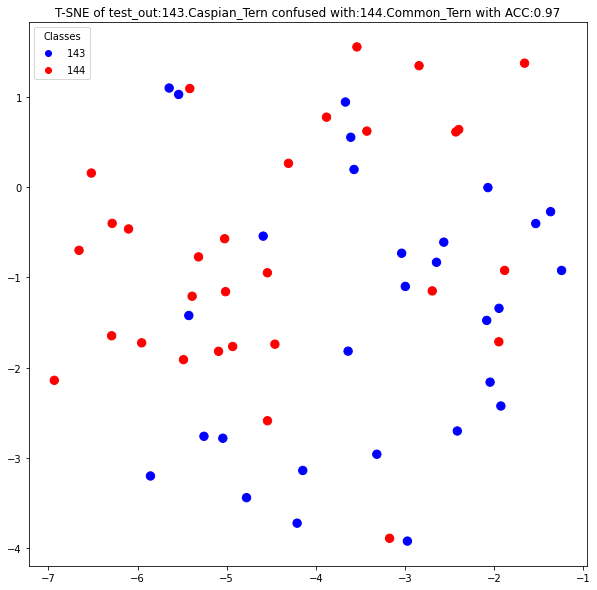

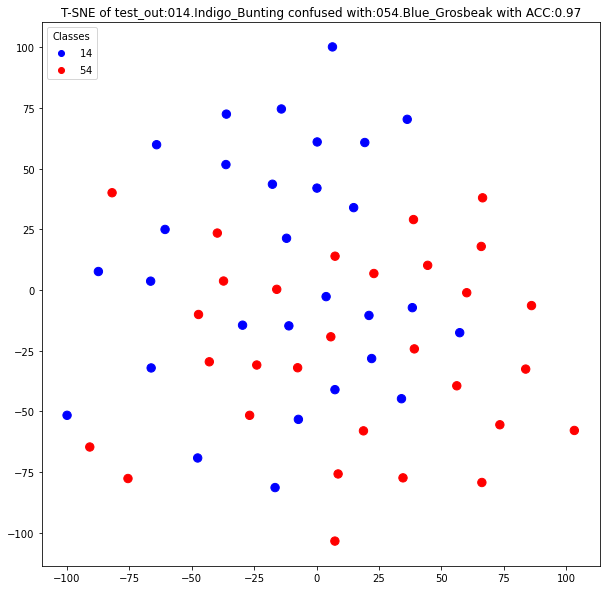

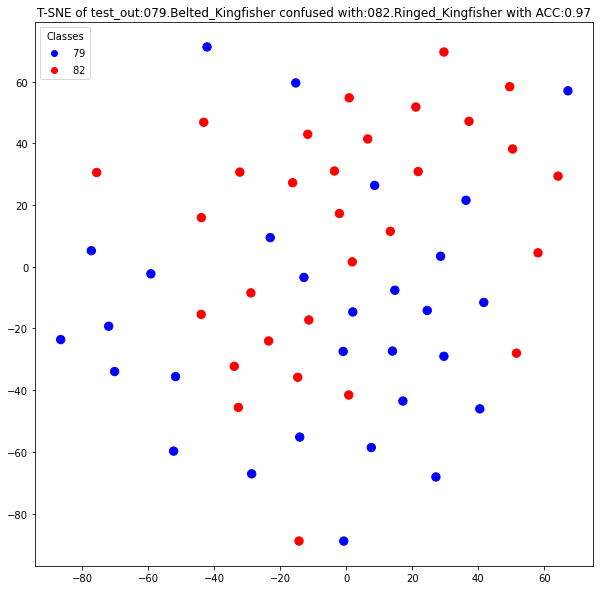

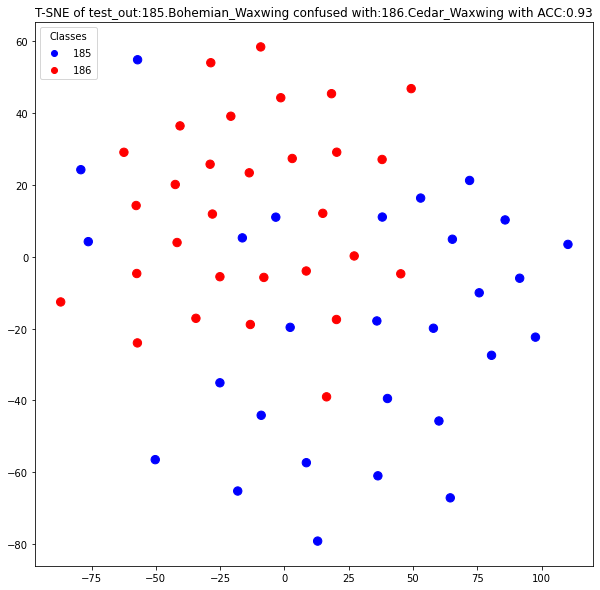

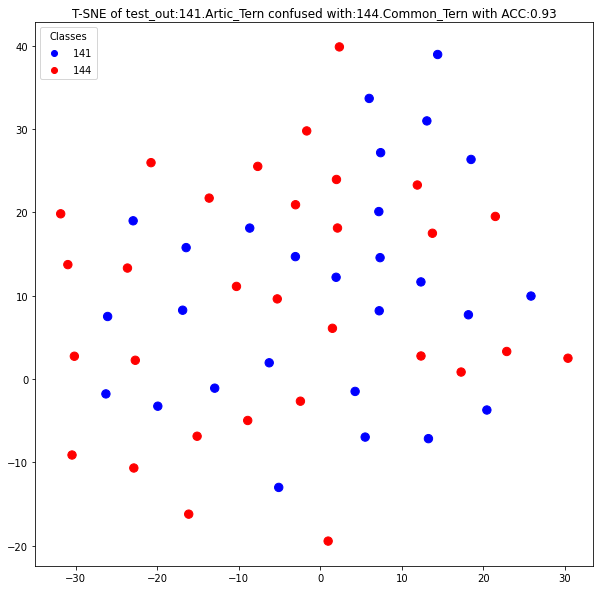

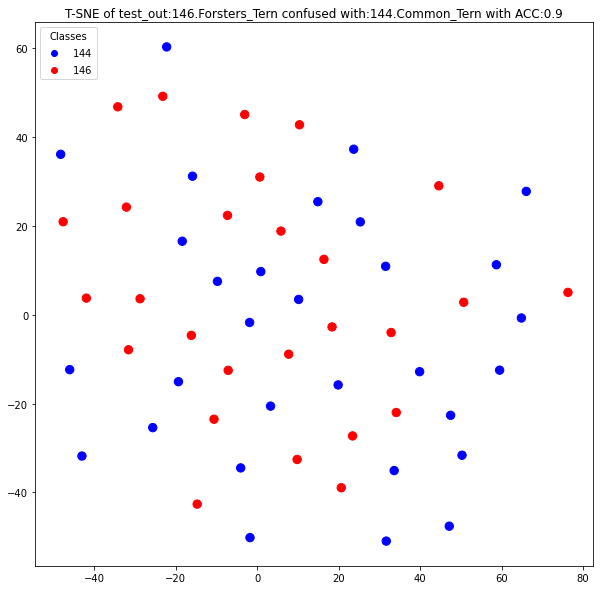

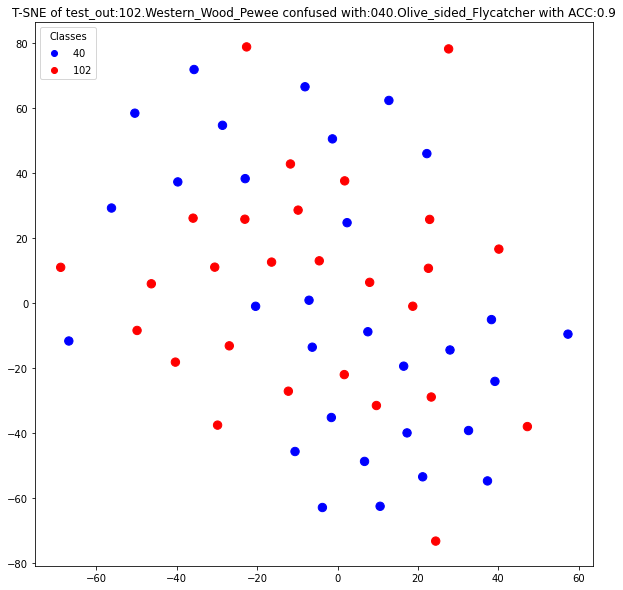

In [17]:
for ix, row in test_out_MOST_confused_classes_df.iterrows():
    test_in_class_vectors = test_in_df[
                        test_in_df['true_class_names']==row['Most Predicted Class']]
    
    
    test_out_class_vectors = test_out_df[(test_out_df['true_class_names']==row['True Class']) &
                                         (test_out_df['pred_class_names']==row['Most Predicted Class'])]
    
    test_class_vectors = pd.concat([test_in_class_vectors, test_out_class_vectors], axis=0)
    
    visualize_tsne(test_class_vectors, row)

In [18]:
test_out_LEAST_confused_classes_df = test_out_confused_classes_df[test_out_confused_classes_df['Accuracy of most predicted class'] <= 0.24]

In [19]:
test_out_LEAST_confused_classes_df

,True Class,Most Predicted Class,Accuracy of most predicted class
92,034.Gray_crowned_Rosy_Finch,035.Purple_Finch,0.24
93,019.Gray_Catbird,094.White_breasted_Nuthatch,0.24
94,166.Golden_winged_Warbler,165.Chestnut_sided_Warbler,0.24
95,136.Barn_Swallow,138.Tree_Swallow,0.23
96,045.Northern_Fulmar,063.Ivory_Gull,0.23
97,038.Great_Crested_Flycatcher,170.Mourning_Warbler,0.20
98,122.Harris_Sparrow,132.White_crowned_Sparrow,0.17
99,085.Horned_Lark,076.Dark_eyed_Junco,0.17


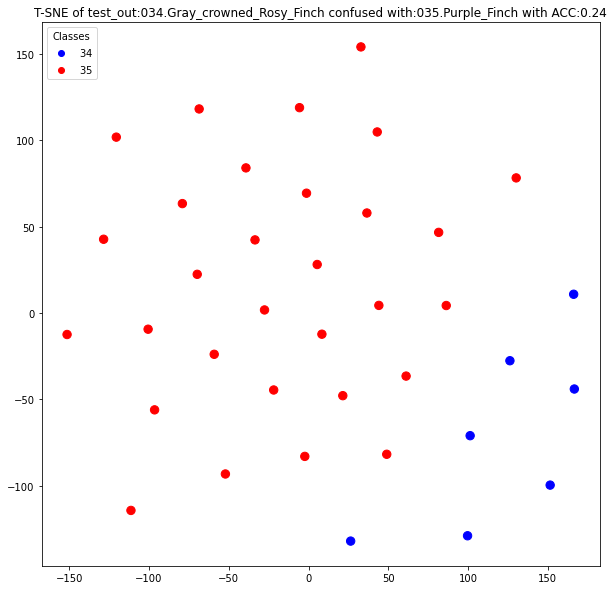

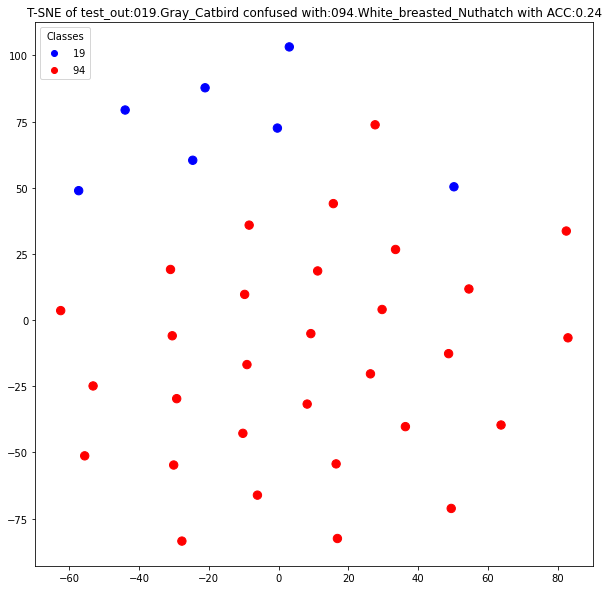

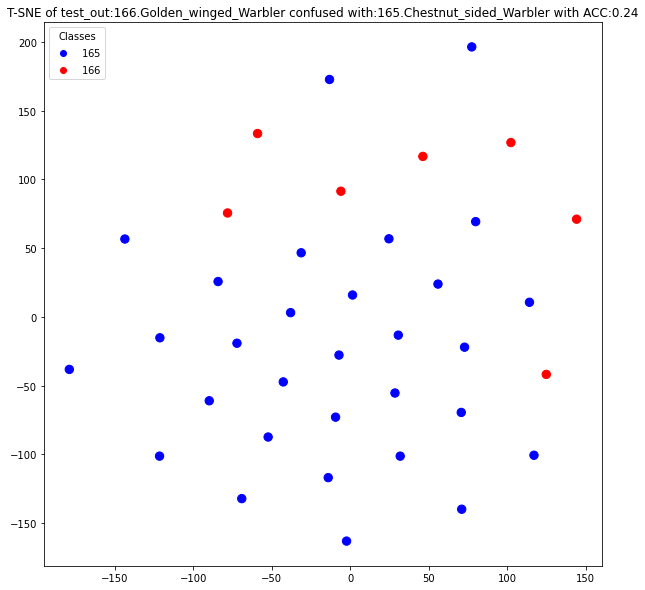

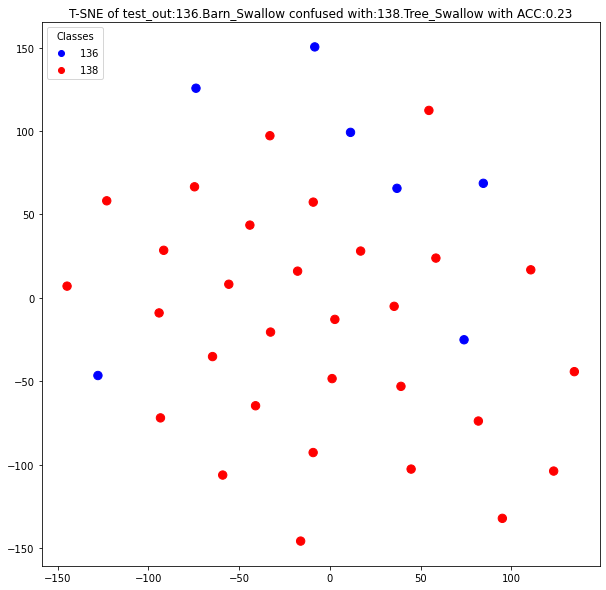

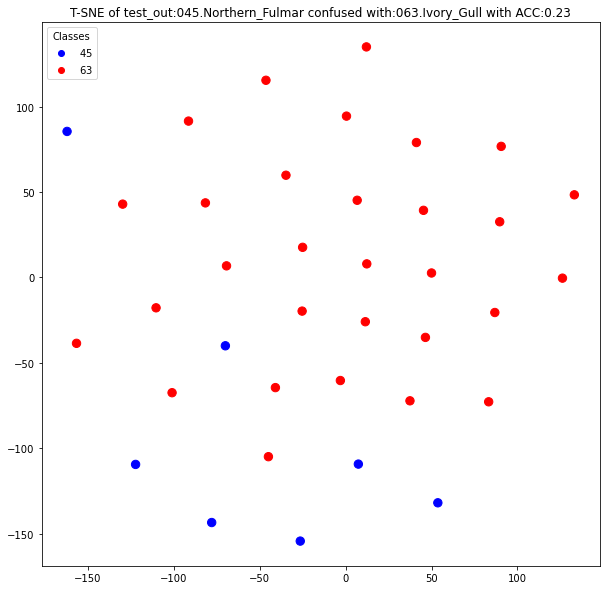

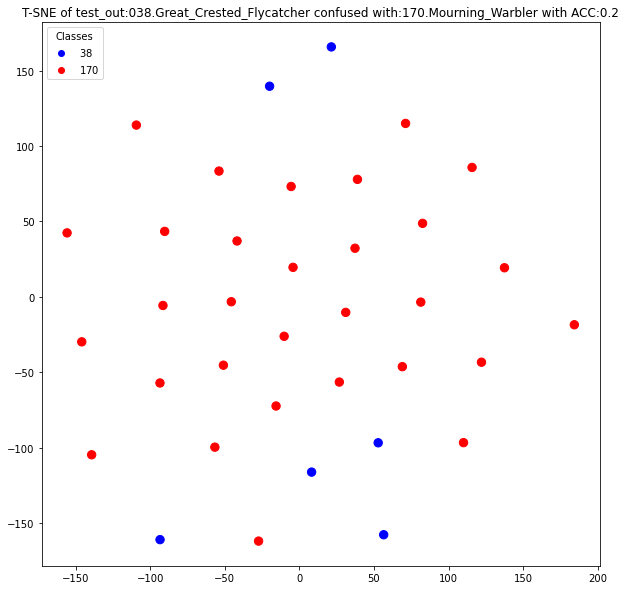

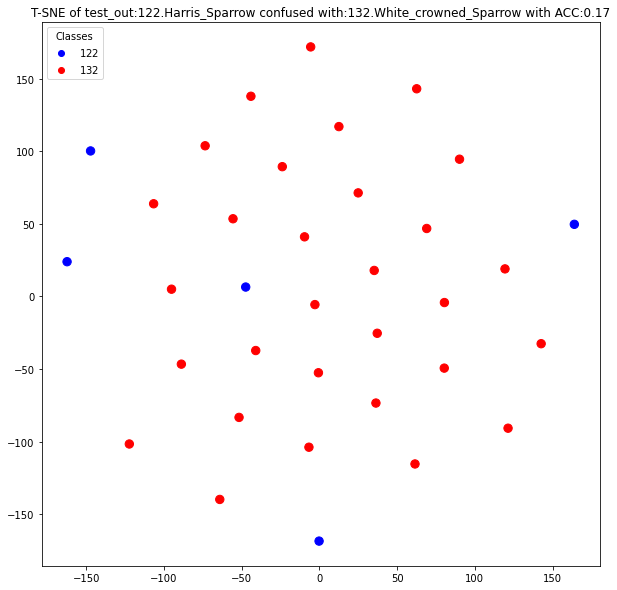

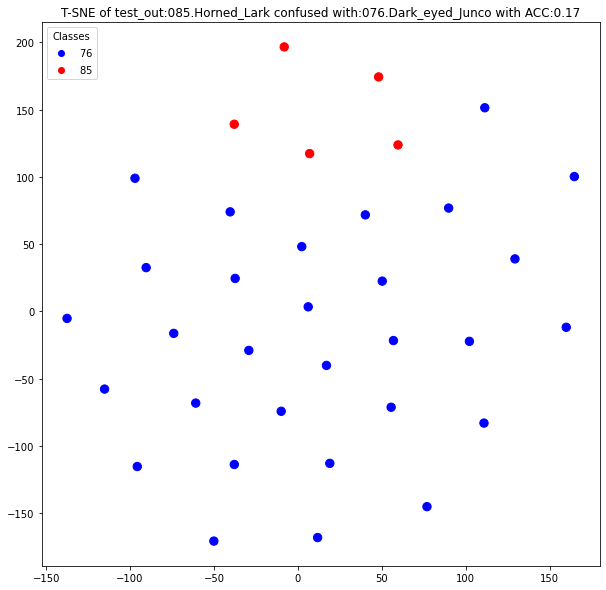

In [20]:
for ix, row in test_out_LEAST_confused_classes_df.iterrows():
    test_in_class_vectors = test_in_df[
                        test_in_df['true_class_names']==row['Most Predicted Class']]
    
    
    test_out_class_vectors = test_out_df[(test_out_df['true_class_names']==row['True Class'])
                                        & (test_out_df['pred_class_names']==row['Most Predicted Class'])
                                        ]
    
    test_class_vectors = pd.concat([test_in_class_vectors, test_out_class_vectors], axis=0)
    
    visualize_tsne(test_class_vectors, row)

# Now let's see the activation maps of confused classes pairs

In [26]:
def show_overlayed_image(overlayed_image):
    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()

In [27]:
def generate_activation_map(image, model):

    model.eval()
    with torch.no_grad():
        image = image.cuda()
        proto_dist_torch = model.prototype_distances(image)
        protoL_input_torch = model.conv_features(image)

    proto_dist_ = np.copy(proto_dist_torch.detach().cpu().numpy())

    prototype_shape = model.prototype_shape
    n_prototypes = prototype_shape[0]
    max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]

    # Use the first prototype as an example
    j = np.unravel_index(np.argmin(proto_dist_), proto_dist_.shape)[1]

    # Calculate the prototype distance
    proto_dist_j = proto_dist_[:, j]

    # Get the original image
    original_img_j = image.squeeze(0).cpu().numpy()
    original_img_j = np.transpose(original_img_j, (1, 2, 0))
    original_img_size = original_img_j.shape[0]
    original_img_j = (original_img_j - np.min(original_img_j)) / np.max(original_img_j - np.min(original_img_j))

    # Calculate the prototype activation
    proto_dist_img_j = proto_dist_[0, j, :, :]
    if model.prototype_activation_function == 'log':
        proto_act_img_j = np.log((proto_dist_img_j + 1) / (proto_dist_img_j + model.epsilon))
    elif model.prototype_activation_function == 'linear':
        proto_act_img_j = max_dist - proto_dist_img_j
    else:
        proto_act_img_j = prototype_activation_function_in_numpy(proto_dist_img_j)

    # Upsample the activation map and create the heatmap
    upsampled_act_img_j = cv2.resize(proto_act_img_j, dsize=(original_img_size, original_img_size), interpolation=cv2.INTER_CUBIC)
    rescaled_act_img_j = upsampled_act_img_j - np.amin(upsampled_act_img_j)
    rescaled_act_img_j = rescaled_act_img_j / np.amax(rescaled_act_img_j)
    heatmap = cv2.applyColorMap(np.uint8(255 * rescaled_act_img_j), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    # heatmap = heatmap[..., ::-1]

    # Overlay the heatmap on the original image
    overlayed_original_img_j = 0.5 * original_img_j + 0.3 * heatmap

    show_overlayed_image(overlayed_original_img_j)

In [28]:
# get class index for "143.Caspian_Tern"
caspian_tern_index = test_out_dataset.class_to_idx['143.Caspian_Tern']

# create an empty list to store images
tern_images = []

# iterate over your dataloader
for images, labels in test_out_loader:
    # find indices of "143.Caspian_Tern" images
    tern_indices = (labels == caspian_tern_index).nonzero(as_tuple=True)[0]
    
    # append "143.Caspian_Tern" images to the list
    tern_images.extend(images[tern_indices])

# convert the list to a torch.Tensor
tern_images = torch.stack(tern_images)

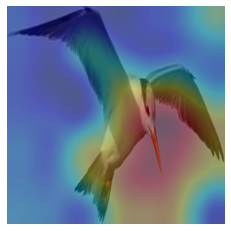

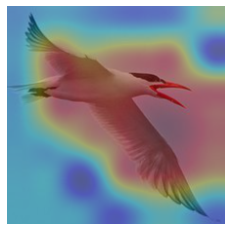

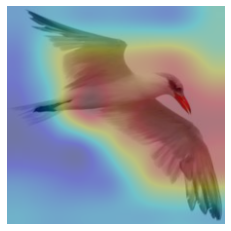

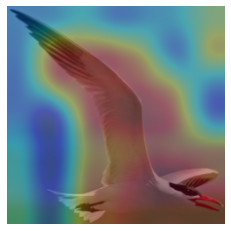

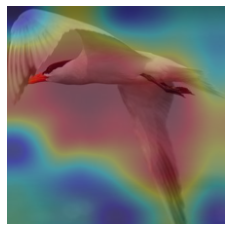

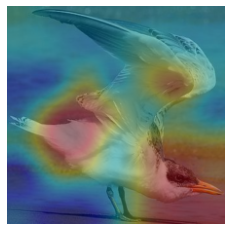

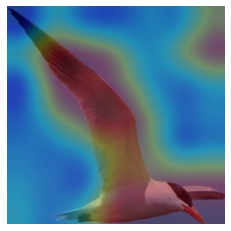

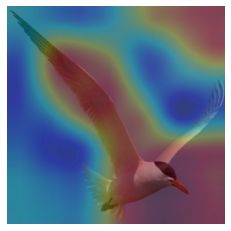

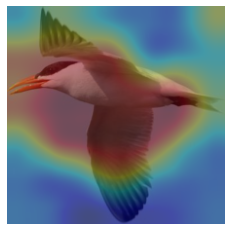

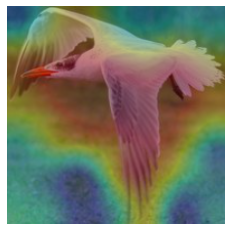

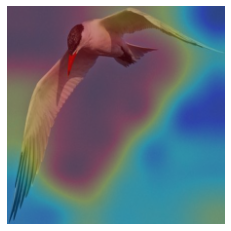

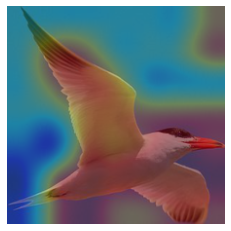

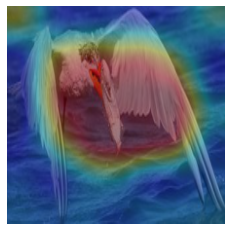

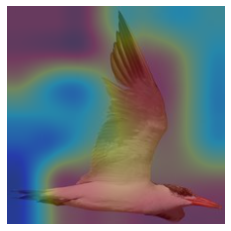

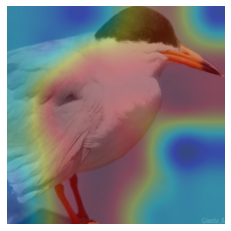

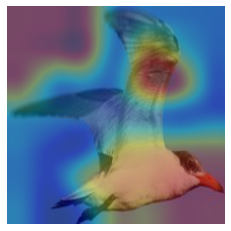

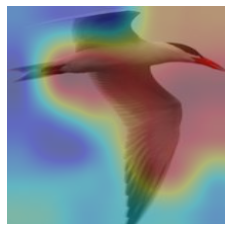

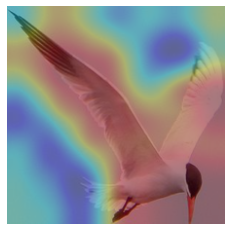

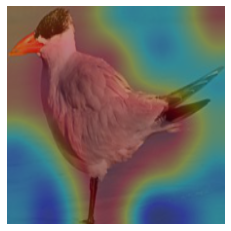

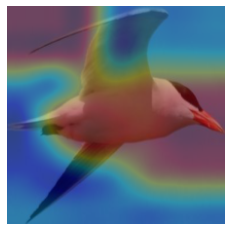

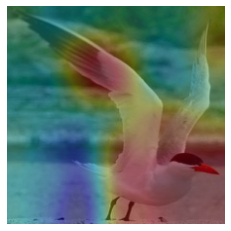

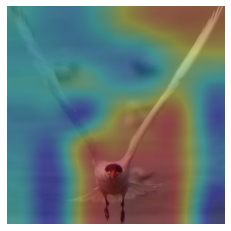

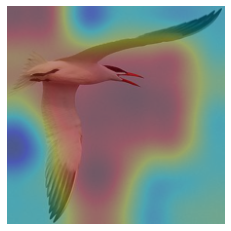

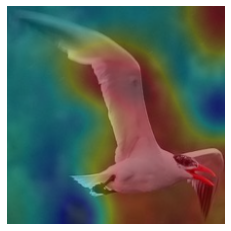

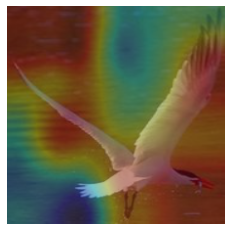

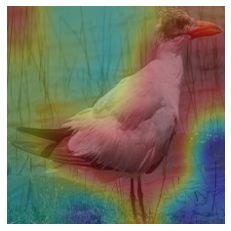

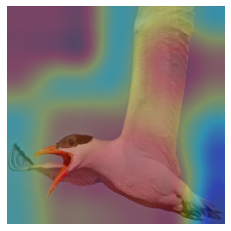

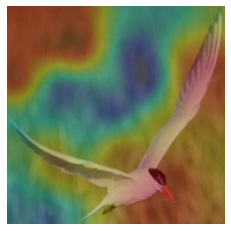

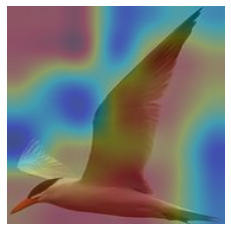

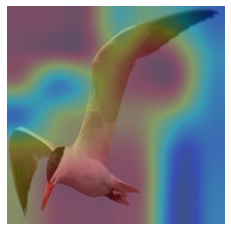

In [29]:
for image in tern_images:
    generate_activation_map(image.unsqueeze(0), model)

# We can see that activation vectors of the most confused classes lay very close to eachother in the latent space. It would be interesting to see if the activation vectors crated with use of train_in or test_in datasets are nicely spaced.

In [21]:
def visualize_tsne(dataset):

    # Create T-SNE model
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-2)

    # Perform T-SNE on the activations
    x_activation_subs_2d = tsne.fit_transform(dataset['x_activation_diffs'])

    # Function to plot the 2D embeddings
    def plot_embeddings(embeddings_2d, labels, title):
        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', alpha=0.5)
        plt.title(title)
        plt.legend(*scatter.legend_elements(), title="Classes", loc="upper left")
        plt.show()
        


    # Plot the embeddings
    
    # pred_model_idxs - are idx representing classes from given dataset (in or out).
    #                   They are assigned by the dataloader. In other words
    #                   those idx are the 'labels' of images that are feed into the model.
    
    # pred_model_idxs - are idx'labels' that model predicts. Please remember that model was trained
    #                   on train_in_dataset. Thus, when feed with test_out_dataset model
    #                   predicts labels that it thinks best (confuses) with the classes it knows.
    #                   Therefore, in case when we feed the model with train_out_dataset or
    #                   train_out_dataset the pred_model_idxs are idxs that model confuses with 
    #                   the classes it knows.
    
    plot_embeddings(x_activation_subs_2d, dataset['true_model_idxs'], 'T-SNE of x_activation_diffs (true_model_idxs)')
    plot_embeddings(x_activation_subs_2d, dataset['pred_model_idxs'], 'T-SNE of x_activation_diffs (pred_model_idxs)')

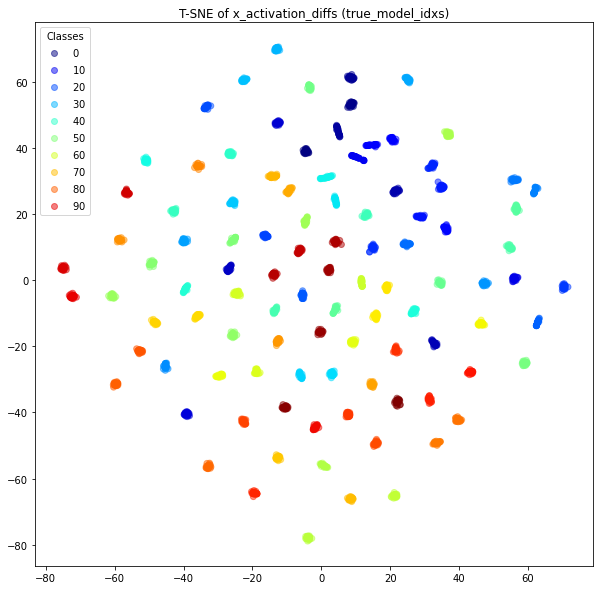

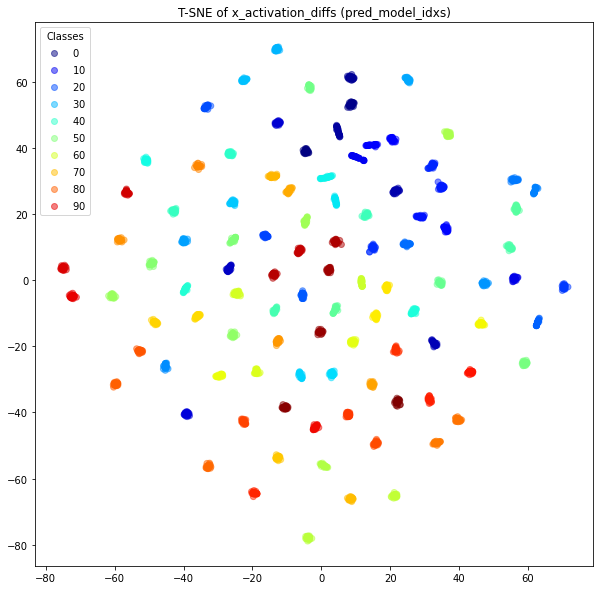

In [22]:
visualize_tsne(train_in_vectors)

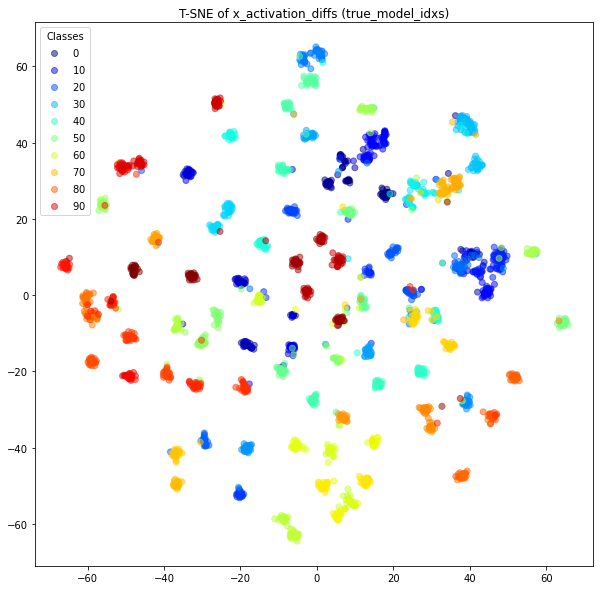

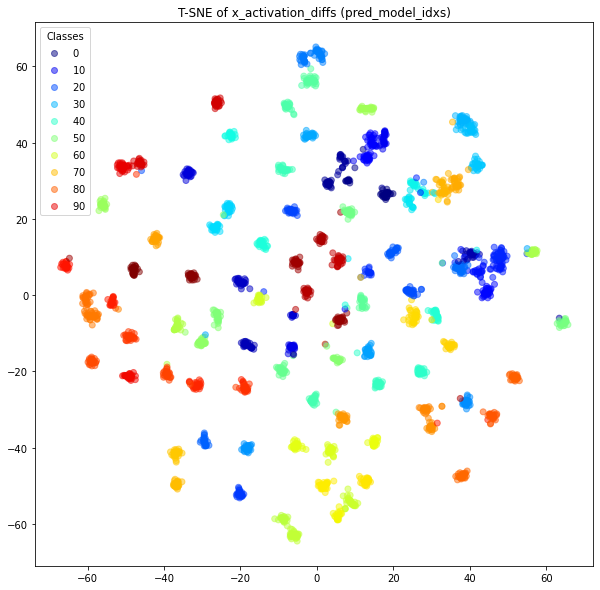

In [23]:
visualize_tsne(test_in_vectors)

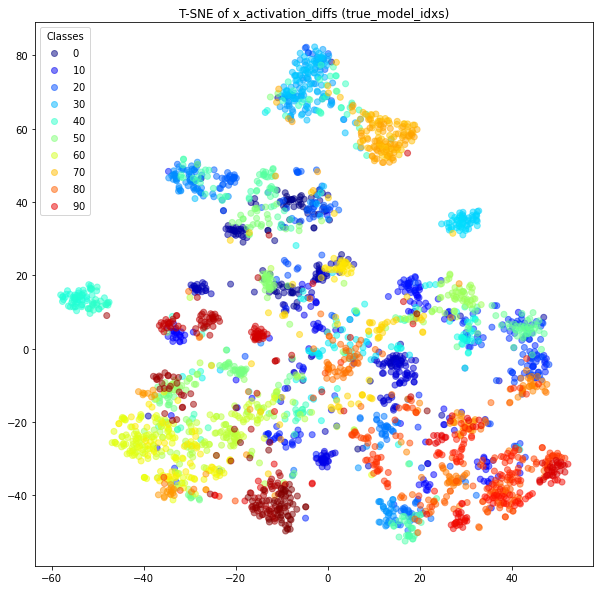

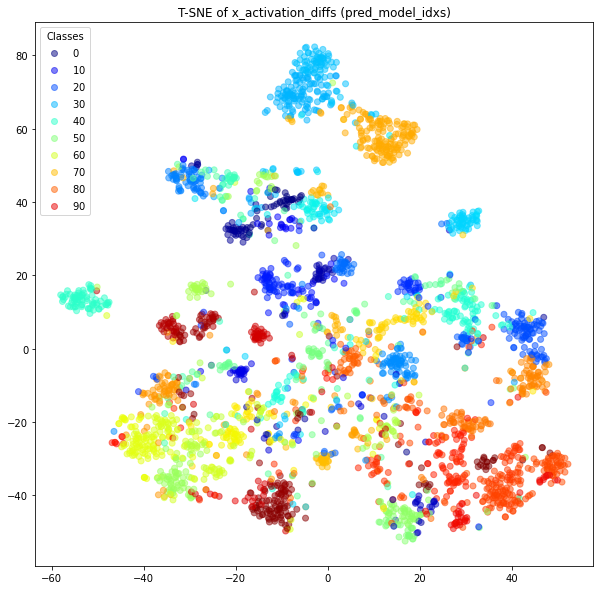

In [24]:
visualize_tsne(train_out_vectors)

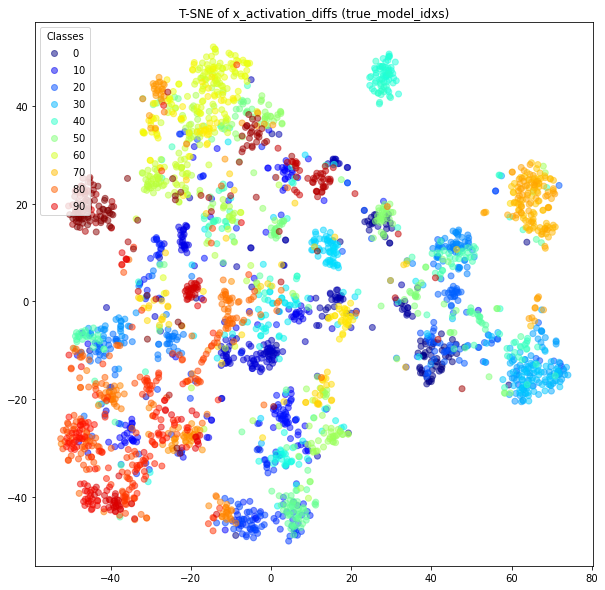

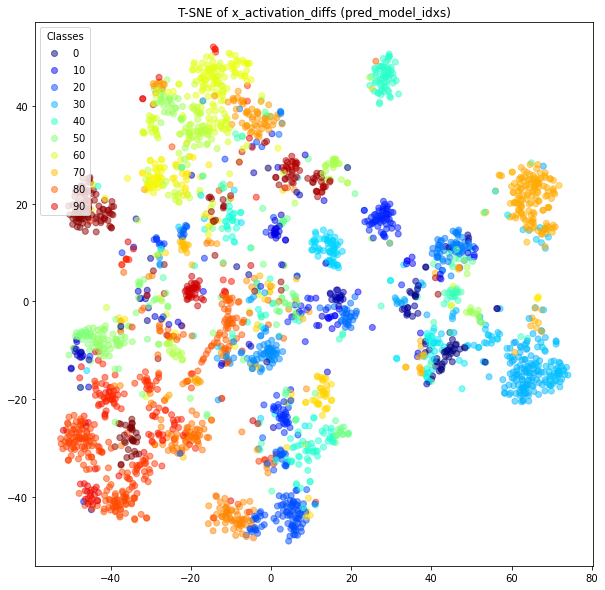

In [25]:
visualize_tsne(test_out_vectors)

In [13]:
def compute_kmeans_accuracy_true_model_idxs(dataset):
    kmeans = KMeans(n_clusters=100, random_state=0, n_init=100).fit(dataset['x_activation_diffs'])
    dataset['kmeans_labels'] = kmeans.labels_
    # Compute the confusion matrix
    cm = confusion_matrix(dataset['true_model_idxs'], dataset['kmeans_labels'])

    # Find the optimal assignment using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Calculate the accuracy
    adjusted_accuracy = cm[row_ind, col_ind].sum() / np.sum(cm)

    print("Adjusted accuracy:", adjusted_accuracy)

In [14]:
compute_kmeans_accuracy_true_model_idxs(train_in_vectors)

Adjusted accuracy: 0.981320880587058


In [15]:
compute_kmeans_accuracy_true_model_idxs(test_in_vectors)

Adjusted accuracy: 0.8644827586206897


In [16]:
compute_kmeans_accuracy_true_model_idxs(train_out_vectors)

Adjusted accuracy: 0.44893190921228304


In [17]:
compute_kmeans_accuracy_true_model_idxs(test_out_vectors)

Adjusted accuracy: 0.4360746371803732


In [21]:
def compute_kmeans_accuracy_pred_model_idxs(dataset):
    kmeans = KMeans(n_clusters=100, random_state=0, n_init=100).fit(dataset['x_activation_diffs'])
    dataset['kmeans_labels'] = kmeans.labels_
    # Compute the confusion matrix
    cm = confusion_matrix(dataset['pred_model_idxs'], dataset['kmeans_labels'])

    # Find the optimal assignment using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Calculate the accuracy
    adjusted_accuracy = cm[row_ind, col_ind].sum() / np.sum(cm)

    print("Adjusted accuracy:", adjusted_accuracy)

In [22]:
compute_kmeans_accuracy_pred_model_idxs(train_in_vectors)

Adjusted accuracy: 0.981320880587058


In [23]:
compute_kmeans_accuracy_pred_model_idxs(test_in_vectors)

Adjusted accuracy: 0.9248275862068965


In [24]:
compute_kmeans_accuracy_pred_model_idxs(train_out_vectors)

Adjusted accuracy: 0.5403871829105474


In [ ]:
compute_kmeans_accuracy_pred_model_idxs(test_out_vectors)